In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
import cv2
from datetime import timedelta
import math
import random
import pickle
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
from sklearn.model_selection import train_test_split

In [2]:
def balanced_subsample(x,y,subsample_size=1.0):

    class_xs = []
    min_elems = None

    for yi in np.unique(y):
        elems = x[(y == yi)]
        class_xs.append((yi, elems))
        if min_elems == None or elems.shape[0] < min_elems:
            min_elems = elems.shape[0]

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems*subsample_size)

    xs = []
    ys = []

    for ci,this_xs in class_xs:
        if len(this_xs) > use_elems:
            np.random.shuffle(this_xs)

        x_ = this_xs[:use_elems]
        y_ = np.empty(use_elems)
        y_.fill(ci)

        xs.append(x_)
        ys.append(y_)

    xs = np.concatenate(xs)
    ys = np.concatenate(ys)

    return xs,ys

def load_data(fname):
    with open(fname, mode='rb') as f:
        data = pickle.load(f)
    x, y = data['features'], data['labels']
    return x, y
    #return shuffle(x, y)

def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        #ax.imshow(images[i].reshape(img_shape))
        #dst = np.zeros(images[i].shape)
        #img = cv2.normalize(images[i],dst,alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        ax.imshow(np.reshape(images[i],(32,32)), cmap='gray')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

def fix_images(images):
    
    #norm_images = np.array(images, copy=True)
    norm_images = np.zeros((images.shape[0],32,32,1))
    print(norm_images.shape, images.shape)
    kernel_sharpen_1 = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    
    kernel_emboss_1 = np.array([[0,-1,-1],
                                [1,0,-1],
                                [1,1,0]])
    kernel_emboss_2 = np.array([[-1,-1,0],
                                [-1,0,1],
                                [0,1,1]])
    kernel_emboss_3 = np.array([[1,0,0],
                                [0,0,0],
                                [0,0,-1]])    
    i_min = np.min(images)
    i_max = np.max(images)
    i_mean = np.mean(images)
    for i in range(0,len(images)):
        dst = np.zeros(images[0].shape)
        #norm_images[i] = cv2.normalize(images[i],dst,alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        n_img = images[i]
        #n_img = cv2.normalize(n_img,dst,alpha=0, beta=128, norm_type=cv2.NORM_MINMAX)
        
        n_img = cv2.cvtColor(n_img, cv2.COLOR_RGB2GRAY)
        
        #n_img = cv2.equalizeHist(n_img)
        
        
        n_img = (n_img-i_mean)/(np.max(i_max)-np.min(i_min))
        n_img = cv2.filter2D(n_img, -1, kernel_sharpen_1)
        
        norm_images[i] = np.reshape(n_img,(32,32,1))
    return norm_images


In [3]:
X_train, y_train = load_data('../datasets/traffic-signs-data/train.p')
X_train1, y_train1 = load_data('../datasets/traffic-signs-data/train.p')
X_train = fix_images(X_train)

y_train = y_train.astype(int)
print(X_train.shape, y_train.shape, y_train)
X_test, y_test = load_data('../datasets/traffic-signs-data/test.p')
X_test = fix_images(X_test)

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
#X_test, X_validation, y_test, y_validation = train_test_split(X_validation, y_validation, test_size=0.50, random_state=42)

(39209, 32, 32, 1) (39209, 32, 32, 3)
(39209, 32, 32, 1) (39209,) [ 0  0  0 ..., 42 42 42]
(12630, 32, 32, 1) (12630, 32, 32, 3)


In [4]:
assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
assert(len(X_test) == len(y_test))

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_validation)))
print("Test Set:       {} samples".format(len(X_test)))


Image Shape: (32, 32, 1)

Training Set:   31367 samples
Validation Set: 7842 samples
Test Set:       12630 samples


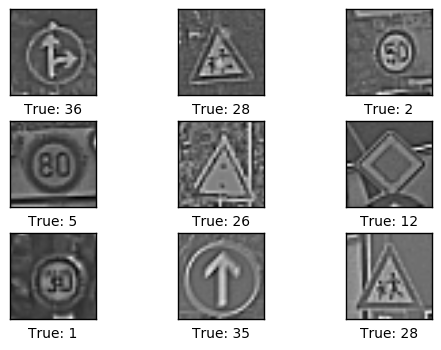

In [5]:
plot_images(X_train[0:9], y_train[0:9])

In [6]:
EPOCHS = 10
BATCH_SIZE = 256

filter_size1 = 4
num_filters1 = 8

filter_size2 = 5
num_filters2 = 16

filter_size3 = 5
num_filters3 = 32


fc_size = 128

img_size = X_train[0].shape[0]

img_size_flat = X_train[0].shape[1] * X_train[0].shape[0]

img_shape = (img_size, img_size)

num_channels = X_train[0].shape[2]
num_classes = max(y_train)+1

stddev=0.1

rate = 0.0001

#keep_prob = tf.placeholder("float")
keep_prob = tf.placeholder(tf.float32, (None))


In [7]:
def new_weights(shape, mu=0, sigma=0.1):
    return tf.Variable(tf.truncated_normal(shape, mean=mu, stddev=sigma))

def new_biases(length):
    return tf.Variable(tf.zeros(length))
    


In [8]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(shape=shape)
    biases = new_biases(length=num_filters)
    layer = tf.nn.conv2d(input, weights, strides=[1, 1, 1, 1], padding='SAME')
    layer += biases
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    layer = tf.nn.relu(layer)
    print ('Layer: {}'.format(shape))
    return layer, weights

In [9]:
def flatten_layer(layer):
    return flatten(layer)

In [10]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    layer = tf.matmul(input, weights) + biases
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [11]:
def LeNet(x):
    mu = 0
    sigma = 0.1
    layer_conv1, weights_conv1 = \
        new_conv_layer(input=x,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)  
        
    layer_conv2, weights_conv2 = \
        new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)        

    layer_conv3, weights_conv3 = \
        new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=True)        
        
    fc0 = flatten(layer_conv2)
    fc1 = new_fc_layer(fc0,1024,fc_size)
    dropout = tf.nn.dropout(fc1, keep_prob)
    #fc2 = new_fc_layer(dropout,fc,640)
    
    logits = new_fc_layer(dropout,fc_size,num_classes)
    return logits

In [12]:
def evaluate(X_data, y_data, sess):
    num_examples = len(X_data)
    total_accuracy = 0
    if sess is None:
        sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [13]:
x = tf.placeholder(tf.float32, (None, img_size, img_size, num_channels))
y = tf.placeholder(tf.int32, (None))

one_hot_y = tf.one_hot(y, num_classes)

In [14]:
logits = LeNet(x)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y_pred, dimension=1)


cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
#cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits, one_hot_y)

loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

Layer: [4, 4, 1, 8]
Layer: [5, 5, 8, 16]
Layer: [5, 5, 16, 32]


In [15]:
#session = tf.Session(tf.ConfigProto(inter_op_parallelism_threads=4,
#                   intra_op_parallelism_threads=4))
#sess = tf.Session(tf.ConfigProto(inter_op_parallelism_threads=4,
#           intra_op_parallelism_threads=4))

#server = tf.train.Server.create_local_server()

with tf.Session() as sess:
#def run_net(sess, X_train, y_train):
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(3):
        X_train, y_train = shuffle(X_train, y_train)
        xx, yy = balanced_subsample(X_train, y_train)
        yy = yy.astype(int)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = xx[offset:end], yy[offset:end]
            sess.run(training_operation, 
                     feed_dict={x: batch_x, y: batch_y, keep_prob:0.5})
            
        validation_accuracy = evaluate(X_validation, y_validation, sess)
        print("{} Validation Accuracy = {:.3f}".format(i+1, validation_accuracy))
        
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, 'explore1')
    print("Model saved")
    
#run_net(session, X_train , y_train)
#session.close()

Training...

1 Validation Accuracy = 0.042
2 Validation Accuracy = 0.052
3 Validation Accuracy = 0.058
Model saved


In [16]:
def plot_example_errors(cls_pred, incorrect, x, y):
    #incorrect = (correct == False)
    images = x[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = y[incorrect]
    plot_images(images=x[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [17]:
X_train.shape

(31367, 32, 32, 1)

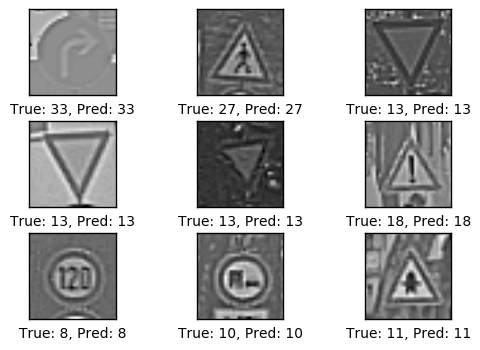

In [18]:
#X_train, y_train = shuffle(X_train, y_train)
plot_images(X_train[0:9], y_train[0:9], y_train[0:9])

In [19]:
test_batch_size = BATCH_SIZE

def print_test_accuracy(X_train, y_train, y_pred_cls, sess, show_example_errors=False,
                        show_confusion_matrix=False):

    num_examples = len(y_train)
    print(num_examples)
    
    cls_pred = np.zeros(shape=num_examples, dtype=np.int)
    i = 0
    
    x_t, y_t = shuffle(X_train,y_train)
    for offset in range(0, num_examples, test_batch_size):
        end = offset + test_batch_size
        batch_x, batch_y = x_t[offset:end], y_t[offset:end]
        feed_dict={x: batch_x, y: batch_y, keep_prob:1}
        cls_pred[offset:end] = sess.run(y_pred_cls, feed_dict=feed_dict)

    cls_true = y_t
    correct = (cls_true == cls_pred)
    incorrect = (cls_true != cls_pred)
    incorrect_labels = y_t[incorrect]
    correct_labels = y_t[correct]
    
    print(len(cls_pred), len(y_t), (cls_true != cls_pred))
    
    #correct_sum = correct.sum()
    #acc = float(correct_sum) / num_test

    # Print the accuracy.
    #msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    #print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors: {}",cls_pred)
        imgs = x_t[cls_pred != y_t]
        plot_images(imgs[0:9], y_t[y_t != cls_pred][0:9], cls_pred[cls_pred != y_t][0:9])
        #plot_example_errors(cls_pred, incorrect, imgs, incorrect)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)
        
    return confusion_matrix(y_t, cls_pred)

12630
12630 12630 [ True  True  True ...,  True  True  True]
Example errors: {} [32 29 27 ..., 27 15  4]


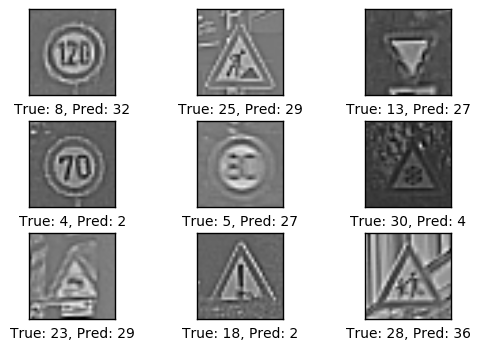

[[ 2  0  1 ...,  4  0  0]
 [20  0 29 ..., 67  1 17]
 [18  0 40 ..., 63  0 13]
 ..., 
 [ 0  0  0 ...,  2  0  3]
 [ 0  0  0 ...,  5  0  2]
 [ 2  0  2 ...,  4  0  0]]


In [20]:
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('explore.meta')
    #sess.run(tf.global_variables_initializer())
    loader.restore(sess, tf.train.latest_checkpoint('./'))

    cm = print_test_accuracy(X_test, y_test, y_pred_cls, sess, True)
    print(cm)

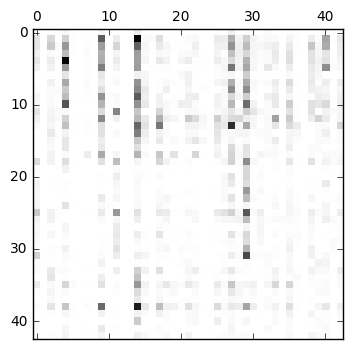

In [21]:
plt.matshow(cm, cmap=plt.cm.binary)

In [22]:
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('explore.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))

    test_accuracy = evaluate(X_test, y_test, sess)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.052


In [ ]:
plot_images(X_validation[y_validation==26][0:9], y_validation[y_validation==26][0:9])

In [ ]:
h= plt.hist(y_train, bins=43)

In [ ]:
xt, yt = balanced_subsample(X_train, y_train, 1)
h = plt.hist(yt, bins=43)